In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re
from nltk.corpus import stopwords

from pymystem3 import Mystem

import string
import time

import emoji
from tqdm import tqdm

from joblib import Parallel, delayed

from wordcloud import WordCloud
import spacy

In [198]:
columns = ['comment', 'date_time', 'color','size', 'thumb_up', 'thumb_down', 'prod_eval', 'prod', 'brand']

df = pd.read_json('./input/file_7961412_455951711_109.jl').transpose().reset_index().drop('index', axis=1)
df = df.set_axis(columns, axis = 'columns')

df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind


# stopwords extend

In [199]:
# нужно обновить стоп-слова, добавив как миниму то, что в облаке. Сейчас использую стоп-слова NLTK, 
# но стоит сравнить с другими
russian_stopwords = stopwords.words("russian")
print(len(russian_stopwords))
russian_stopwords.extend(['очень', 'хороший', 'отличный', 'свой', 'отзыв', 'миксер', 'супер','это', 'спасибо', 'работа',
                          re.sub(r'[.,?!@#~`$%^&*_+-=]', '', df['brand'][0].lower()), 
                          re.sub(r'[.,?!@#~`$%^&*_+-=]', '', df['prod'][0].lower())])
print(len(russian_stopwords))

151
163


In [200]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind


# очистка текста (эмодзи, стоп-слова, символы)

In [201]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

    text = text.translate(string.punctuation)
    text = text.lower().split()
    text = [w for w in text if not w in russian_stopwords and len(w) >= 3]
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[,!.\/'+-=)(]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\%", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\|", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(text.split())
    

    return text


In [202]:
df['cleaned_comment'] = df['comment'].map(lambda x: clean_text(x))

In [203]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...


# Mystem и удаление опустевших комментов

In [204]:
df[df['cleaned_comment']=='']

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
71,Отличный миксер,2021-03-25T05:30:48Z,фиолетовый,0,2,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
87,Отличный миксер,2021-03-15T06:29:58Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,
188,Отличный миксер,2021-01-05T11:04:48Z,фиолетовый,0,1,2,5,Миксер планетарный SPM7167 1600Вт,StarWind,
217,Супер миксер,2021-01-02T13:21:52Z,фиолетовый,0,2,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
474,Отличный миксер,2020-11-25T06:30:41Z,фиолетовый,0,1,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
484,😍😍😍👍👍👍,2020-11-23T09:34:17Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,
505,Отличный миксер,2020-11-20T04:56:31Z,фиолетовый,0,3,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,


In [205]:
df = df.drop(df[df['cleaned_comment']==''].index)

In [206]:
def lemmatize(text): 
    text =  [i for i in text]
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    count = 0
    lemma = m.lemmatize(merged_text)
    for t in lemma:
        
        if t != '|' and count+1<len(lemma):
            doc.append(t)
            count+=1
          
        else:
            doc = ''.join(i for i in doc)
            res.append(doc)
            count+=1
            doc = []
    return res

In [207]:
res = lemmatize(df['cleaned_comment'])

In [208]:
df['lemma_comment'] = res

In [210]:
df['lemma_comment'] = df['lemma_comment'].map(lambda x: clean_text(x))
df = df.drop(df[df['lemma_comment']==''].index)

In [227]:
df = df.reset_index(inplace = True)
#df = df.drop(columns = 'index')
#df

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился,зверь машина понравиться
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую,аллах советовать
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...,приходить целое попробовать понравиться шумный...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...,хотеть долго выбирать купить красивый цвет раб...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...,сегодня получать сразу опробовать дело успеват...
...,...,...,...,...,...,...,...,...,...,...,...
668,Это просто супер. Немогу нарадоваться ему. Раб...,2019-09-12T06:54:51.961383438Z,фиолетовый,0,5,4,5,Миксер стационарный SPM7167 1600Вт,StarWind,просто супер немогу нарадоваться ему работает ...,просто немогать нарадоваться работать мощно ти...
669,"18.07.2019 прибыл данный агрегат в наш дом, же...",2019-08-26T18:09:34.246907845Z,фиолетовый,0,8,0,5,Миксер стационарный SPM7167 1600Вт,StarWind,прибыл данный агрегат наш дом жена решила сраз...,прибывать данный агрегат наш дом жена решать с...
670,Миксер просто бомба! Пришёл в двойной упаковке...,2019-08-24T09:31:08.725139922Z,фиолетовый,0,4,0,5,Миксер стационарный SPM7167 1600Вт,StarWind,просто бомба пришёл двойной упаковке всё налич...,просто бомба приходить двойной упаковка наличи...
671,"Вчера получила миксер,муж подарил на 30 летие ...",2019-07-06T07:34:02.483280032Z,фиолетовый,0,5,2,5,Миксер стационарный SPM7167 1600Вт,StarWind,вчера получила миксер муж подарил летие совмес...,вчера получать муж подарить летие совместный ж...


In [228]:
preprocessed_comments = df['lemma_comment']

## LDA

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [71]:
voc={}
count=0
for i in ((df['lemma_comment'])):
  for j in i.split(' '):
      
      if j not in voc:
          voc[j]=count
          count+=1

In [72]:
count_vect = CountVectorizer(vocabulary=voc)
dataset = count_vect.fit_transform(df['lemma_comment'])

In [73]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components = 40, max_iter=40, n_jobs=6, learning_method='batch', verbose=1)
lda.fit(dataset)

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40
iteration: 31 of max_iter: 40
iteration: 32 of max_iter: 40
iteration: 33 of max_iter: 40
iteration: 34 of ma

LatentDirichletAllocation(max_iter=40, n_components=40, n_jobs=6, verbose=1)

In [74]:
LDA(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.6,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=30, mean_change_tol=0.0001,
             n_components=60, n_jobs=6,  perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=10000.0, verbose=1)

LatentDirichletAllocation(learning_decay=0.6, max_iter=30,
                          mean_change_tol=0.0001, n_components=60, n_jobs=6,
                          total_samples=10000.0, verbose=1)

In [75]:
#Let\`s do simple interface class
class TopicModeler(object):
    '''
    Inteface object for CountVectorizer + LDA simple
    usage.
    '''
    def __init__(self, count_vect, lda):
        '''
        Args:
             count_vect - CountVectorizer object from sklearn.
             lda - LDA object from sklearn.
        '''
        self.lda = lda
        self.count_vect = count_vect
        self.count_vect.input = 'content'
        
    def __call__(self, text):
        '''
        Gives topics distribution for a given text
        Args:
             text - raw text via python string.
        returns: numpy array - topics distribution for a given text.
        '''
        vectorized = self.count_vect.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    def get_keywords(self, text, n_topics=5, n_keywords=5):
        '''
        For a given text gives n top keywords for each of m top texts topics.
        Args:
             text - raw text via python string.
             n_topics - int how many top topics to use.
             n_keywords - how many top words of each topic to return.
        returns:
                list - of m*n keywords for a given text.
        '''
        lda_topics = self(text)
        lda_topics = np.squeeze(lda_topics, axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]
        
        top_topics_words_dists = []
        for i in n_topics_indices:
            top_topics_words_dists.append(self.lda.components_[i])
        
        keywords = np.zeros(shape=(n_keywords*n_topics, self.lda.components_.shape[1]))
        for i,topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k,j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
        keywords = self.count_vect.inverse_transform(keywords)
        keywords = [keyword[0] for keyword in keywords]
        return keywords

In [76]:
#text=''.join(df['filtered_tokens_str'])
text = ' '.join(df['comment'])
#text

In [77]:
tm = TopicModeler(count_vect, lda)

# Topics

In [90]:
#Let`s what words it will give us for the choosen text.
key_words = tm.get_keywords(text, n_topics=5, n_keywords=1)
print(key_words)

['пункт', 'коробка', 'взбивать', 'насадка', 'довольный']


In [91]:
term_doc_matrix = count_vect.transform(df['lemma_comment'])
embeddings = lda.transform(term_doc_matrix)

In [92]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering, KMeans

In [99]:
kmeans = KMeans(n_clusters=5)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

In [100]:
embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)

tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [101]:
from matplotlib import cm as cm
clust_indices = np.unique(clust_labels)

In [102]:
clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

In [103]:
for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

In [104]:
len(clust_labels)

673

#  выдача комментов

In [106]:
count=0
for i in range(len(clust_labels)):
    if clust_labels[i]==2:
        print(df['comment'][i])

Очень понравился три насадки и лопатка селиконовая была в комплекте тесто замешивает хорошо делала на куличи руки чистые все насыпала и включил. Так удобно. Спасибо за скидку и быструю доставку.
Миксер очень понравился!
Рекомендую
Пришёл без повреждений, полный комплект
Отличный миксер. Упакован в две коробки. В комплекте три насадки, силиконовая лопатка, инструкция по применению на русском языке. Работает хорошо, уже проверила в деле  - сделала зефир.
Отличный миксер, цвет красивый, сам мощный. В комплекте венчик, крюк для теста, насадка для перемешивания и лопатка. Рекомендую, как хорошего помощника на кухне.
Товар пришел идеально упакован, все в пакетиках. Коробка не мятая. Попробовала включить, и это что-то. Он вообще не шумный, так этого боялась ))) Чаша шикарная, крепиться хорошо. Присоски к столу, просто восторг. Еле от стола оторвала. Моя мечта сбылась, я нашла то что давно искала )))
Очень классная и мощная машина!!! Тесто для пельменей замешивает без проблем. Белки ,сливки, м

In [88]:
import matplotlib.pyplot as plt

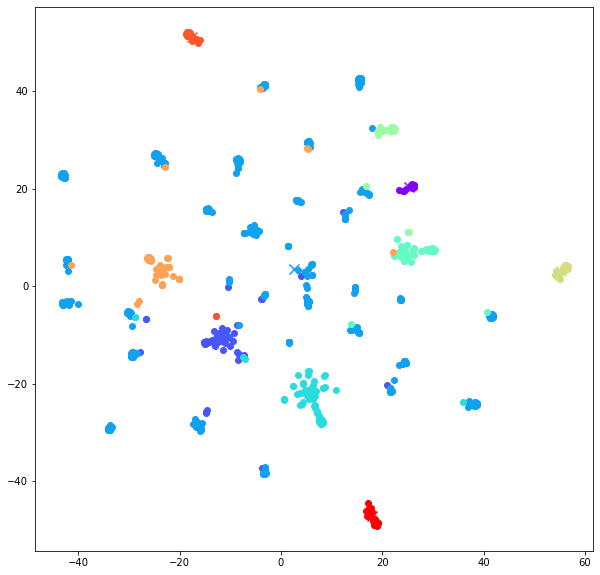

In [89]:
plt.figure(figsize=(10,10))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

plt.show()

## spacy_ru

In [108]:
#python -m spacy download ru_core_news_sm
import spacy
nlp = spacy.load("ru_core_news_sm")

In [110]:
nlp(df['comment'][1])

Миксер очень хороший Ма ша Аллах1 советую 👍

# Word cloud

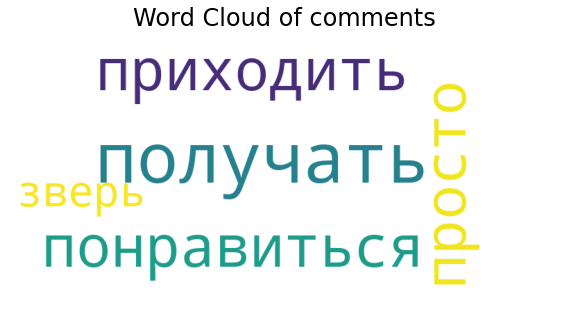

In [229]:
def plot_wordcloud(preprocessed_comments, mask=None, max_words=5, max_font_size=100, figure_size=(8.0,8.0), 
                   title = None, title_size=24, image_color=False):
    stopwords = {}
    wordcloud = WordCloud(background_color='white',
                    mask=None,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 666,
                    contour_width=1,
                    contour_color='black',
                    width=800, 
                    height=400,
                    )
    wordcloud.generate(str(preprocessed_comments))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
plot_wordcloud(preprocessed_comments, title="Word Cloud of comments")

In [231]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился,зверь машина понравиться
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую,аллах советовать
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...,приходить целое попробовать понравиться шумный...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...,хотеть долго выбирать купить красивый цвет раб...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...,сегодня получать сразу опробовать дело успеват...


# tf-idf

In [232]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

In [233]:
vectorized_comments = vectorizer.fit_transform(preprocessed_comments)

In [234]:
#  creating a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [235]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(5)

,tfidf
приходить,2.476278
работать,2.578756
тесто,2.630428
довольный,2.653418
взбивать,2.785842


In [236]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

vectorized_comments = vectorizer.fit_transform(preprocessed_comments)

#  creating a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

tfidf.sort_values(by=['tfidf'], ascending=True).head(5)

,tfidf
приходить,2.476278
работать,2.578756
тесто,2.630428
довольный,2.653418
взбивать,2.785842


# Looking for most similar comments for each word

In [237]:
nlp = spacy.load('ru_core_news_lg')

In [238]:
tfidf.sort_values(by=['tfidf'], ascending=True).index[0]

'приходить'

In [239]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
0,Зверь машина!👌🏻👌🏻очень понравился! Спасибо,2021-05-02T17:40:11Z,фиолетовый,0,1,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,зверь машина очень понравился,зверь машина понравиться
1,Миксер очень хороший Ма ша Аллах1 советую 👍,2021-05-02T08:26:34Z,фиолетовый,0,1,3,5,Миксер планетарный SPM7167 1600Вт,StarWind,аллах советую,аллах советовать
2,Пришло все целое. Попробовала в работе. Понрав...,2021-05-01T21:21:00Z,фиолетовый,0,0,1,5,Миксер планетарный SPM7167 1600Вт,StarWind,пришло целое попробовала работе понравился шум...,приходить целое попробовать понравиться шумный...
3,"Очень хотела, долго выбирала и вот наконец куп...",2021-05-01T18:48:08Z,фиолетовый,0,8,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,хотела долго выбирала купила красивый цвет всё...,хотеть долго выбирать купить красивый цвет раб...
4,Сегодня получила миксер и сразу опробовала в д...,2021-05-01T18:37:37Z,фиолетовый,0,4,0,5,Миксер планетарный SPM7167 1600Вт,StarWind,сегодня получила сразу опробовала деле успела ...,сегодня получать сразу опробовать дело успеват...


In [280]:
def top_10_similar(word_for_checking, dataframe):
    word_for_checking = nlp(word_for_checking)
    similarities = []
    for i in range(len(dataframe['lemma_comment'])):
        similarities.append(nlp(dataframe['lemma_comment'][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    return df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)[['comment', f'similarity_to_{word_for_checking}']]

In [279]:
list(top_10_similar('белок', df))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  """


['Зверь машина!👌🏻👌🏻очень понравился! Спасибо',
 'Брал за 4000р. Сейчас под 6000р. 4000- адекватная цена. За 6000р. Не рекомендую.',
 'Миксер 🔥🔥🔥. Долго выбирала. Остановилась на этом и не жалею  сегодня же сделала зефир, не идет ни в какое сравнение ручным миксером.',
 'Очень красивый и большой!\r\nПока только проверила, без приготовления. Чаша не крутится.\r\nПришел очень хорошо упакованный в две коробки.\r\nНо, почему то не заполнен гарантийный талон.',
 'Все замечательно! Сегодня опробован на пирожках из кефирного теста.\nТестомес пришел упакованный в две коробки. Ничего не помялось.\nК столу крепится присосками. Ничего при работе не прыгало.\nЗащитную крышку пока ге поняла. Окошко маленькое и засыпать через него не удобно.\nОдно яйцо не взбивается.',
 'Все просто супер, не шумный. За такую цену грех жаловаться, долгой службы ему. Гарантия конечто пустая(доставка курьером) упаковано круто!\nЕдинственное что необосновано поднимается цена с карточки товара  в карзину, при оплате она у

In [284]:
top_10_similar('бог', df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  """


,comment,similarity_to_бог
1,Миксер очень хороший Ма ша Аллах1 советую 👍,0.441208
585,Советую. Попробовала меня порадовала. Спасибоч...,0.419345
651,"Приехал наконец то мой красавец, я его появлен...",0.390592
411,"А мечты, оказывается, сбываются ☺️\n10 лет меч...",0.379921
73,Муж подарил мне на день рождения этот прекрасн...,0.376761
646,"Миксер хороший, но буду перезаказывать, не до ...",0.376693
595,Моя любовь!,0.368429
127,Сегодня испекла хлеб. Замесила тесто в миксер...,0.368337
125,Брала за 6716₽ не капли не пожалела пользовала...,0.362049
459,"Миксер супер! Долго выбирала и сомневалась, но...",0.358433


In [19]:
# пока не работает с неизвестными словами, например, "маломерит"
# если пишешь плохое качество, то выдача вроде та же, что и на хорошее
# вся работа у меня заняла 30 секунд